In [33]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from sklearn.preprocessing import FunctionTransformer, PowerTransformer, PolynomialFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, calinski_harabasz_score, silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.cluster import KMeans
# bayestian hyperparameter tunning
import optuna
# models to try
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from myvars import input_features
from myfuncs import num_describe, generate_features
from myclasses import Windsorizer


pd.options.display.max_rows = 200
pd.options.display.max_columns = 200
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [19]:
def custom_score(y, y_pred, **kwargs):
    return mean_squared_error(y_true=np.exp(y), y_pred=np.exp(y_pred))

# Simulate future data

In [20]:
def separate_data():
    data = pd.read_csv('../data/processed/data.csv')
    data = data.dropna(subset=input_features)
    data = generate_features(data)
    data.query("calendarYear > 2018").to_csv('../data/processed/future.csv', index=False)
    data.query("calendarYear <= 2018").to_csv('../data/processed/present.csv', index=False)
    return None

In [21]:
separate_data()

# Train on different models

In [22]:
data = pd.read_csv('../data/processed/present.csv')
features = data.drop(columns=['target', 'symbol', 'calendarYear', 'filingDate'])
target = data.target

#### Train test split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    features,
    np.log(target), 
    test_size=0.25, 
    random_state = 46)
[x.shape for x in [X_train, X_test, y_train, y_test]]

[(5925, 62), (1975, 62), (5925,), (1975,)]

In [24]:
pd.concat([X_train,y_train], axis=1).to_csv('../data/processed/train.csv', index=False)
pd.concat([X_test,y_test], axis=1).to_csv('../data/processed/test.csv', index=False)

#### No model

In [25]:
n = len(y_test)
mean = y_train.mean()
worst_preds = np.tile(mean, n)
mean_squared_error(y_true=np.exp(y_test), y_pred = np.exp(worst_preds))

4624.240947756172

#### Linear Regression

In [26]:
def do_linear_regression(pipe, X_train, X_test, y_train, y_test=None):
    pipe.steps.append(('linear_regression', LinearRegression()))
    pipe.fit(X_train, y_train)
    preds_test = pipe.predict(X_test)
    preds_train = pipe.predict(X_train)
    mse_test = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds_test))
    mse_train = mean_squared_error(y_true=np.exp(y_train), y_pred=np.exp(preds_train))
    print('mse train:', mse_train)
    print('mse test: ', mse_test)
    print('rmse test: ', np.sqrt(mse_test))

In [28]:
mypipe = Pipeline(steps=[
    ('scaler', PowerTransformer()),
    ])
do_linear_regression(mypipe, X_train, X_test, y_train, y_test)

mse train: 999.3981651467957
mse test:  663.5715545296208
rmse test:  25.759882657528173


#### Polynomial Regression

In [35]:
def do_poly_regression(pipe, X_train, X_test, y_train, y_test=None, degree = 2):
    pipe.steps.append(('poly_transform', PolynomialFeatures(degree=degree)))
    pipe.steps.append(('regression', LinearRegression()))
    pipe.fit(X_train, y_train)
    preds_test = pipe.predict(X_test)
    preds_train = pipe.predict(X_train)
    mse_test = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds_test))
    mse_train = mean_squared_error(y_true=np.exp(y_train), y_pred=np.exp(preds_train))
    print('mse train:', mse_train)
    print('mse test: ', mse_test)
    print('rmse test: ', np.sqrt(mse_test))

mypipe = Pipeline(steps=[
    ('scaler', PowerTransformer()),
    ])
do_poly_regression(mypipe, X_train, X_test, y_train, y_test)

mse train: 338.83474939613353
mse test:  2.6017074875005544e+113
rmse test:  5.100693568036169e+56


- **Insane Overfit**. 1e113 order of magnitude

#### Linear SVR

In [83]:
def do_linear_svm_regression(pipe, X_train, X_test, y_train, y_test=None):
    pipe.steps.append(('linear_svm', LinearSVR(C=0.02)))
    pipe.fit(X_train, y_train)
    preds_test = pipe.predict(X_test)
    preds_train = pipe.predict(X_train)
    mse_test = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds_test))
    mse_train = mean_squared_error(y_true=np.exp(y_train), y_pred=np.exp(preds_train))
    print('mse train:', mse_train)
    print('mse test: ', mse_test)
    print('rmse test: ', np.sqrt(mse_test))

mypipe = Pipeline(steps=[
    ('scaler', PowerTransformer()),
    ])
do_linear_svm_regression(mypipe, X_train, X_test, y_train, y_test)

mse train: 1033.6502283339767
mse test:  686.7258782508286
rmse test:  26.205455123901753


- Check ill-conditioning. For C's larger than 0.02 it stops converging despite max_iter being 1000

### SVM with radial basis functions
- Nice

In [92]:
def do_svm_regression(pipe, X_train, X_test, y_train, y_test=None):
    pipe.steps.append(('rbf_svm', SVR(kernel = 'rbf', C=1.5, epsilon=0.1)))
    pipe.fit(X_train, y_train)
    preds_test = pipe.predict(X_test)
    preds_train = pipe.predict(X_train)
    mse_test = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds_test))
    mse_train = mean_squared_error(y_true=np.exp(y_train), y_pred=np.exp(preds_train))
    print('mse train:', mse_train)
    print('mse test: ', mse_test)
    print('rmse test: ', np.sqrt(mse_test))
    return pipe

mypipe = Pipeline(steps=[
    ('scaler', PowerTransformer()),
    ])
do_svm_regression(mypipe, X_train, X_test, y_train, y_test)

mse train: 449.51700186471805
mse test:  481.71800049745985
rmse test:  21.948075097772467


Pipeline(steps=[('scaler', PowerTransformer()), ('rbf_svm', SVR(C=1.5))])

#### KNN

In [116]:
def do_neighbors(pipe, X_train, X_test, y_train, y_test=None):
    pipe.steps.append(('rfe', RFE(estimator = LinearRegression(), n_features_to_select = 2)))
    pipe.steps.append(('knn', KNeighborsRegressor(n_neighbors=8)))
    pipe.fit(X_train, y_train)
    preds_test = pipe.predict(X_test)
    preds_train = pipe.predict(X_train)
    mse_test = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds_test))
    mse_train = mean_squared_error(y_true=np.exp(y_train), y_pred=np.exp(preds_train))
    print('mse train:', mse_train)
    print('mse test: ', mse_test)
    print('rmse test: ', np.sqrt(mse_test))
    return pipe

mypipe = Pipeline(steps=[
    ('scaler', PowerTransformer()),
    ])
do_neighbors(mypipe, X_train, X_test, y_train, y_test)

mse train: 483.4397437974652
mse test:  469.06610344014774
rmse test:  21.657933960563916


Pipeline(steps=[('scaler', PowerTransformer()),
                ('rfe',
                 RFE(estimator=LinearRegression(), n_features_to_select=2)),
                ('knn', KNeighborsRegressor(n_neighbors=8))])

#### Random Forest

In [ ]:
def do_forest(pipe, X_train, X_test, y_train, y_test=None):
    pipe.steps.append(('forest', RandomForestRegressor()))
    pipe.fit(X_train, y_train)
    preds_test = pipe.predict(X_test)
    preds_train = pipe.predict(X_train)
    mse_test = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds_test))
    mse_train = mean_squared_error(y_true=np.exp(y_train), y_pred=np.exp(preds_train))
    print('mse train:', mse_train)
    print('mse test: ', mse_test)
    print('rmse test: ', np.sqrt(mse_test))
    return pipe

mypipe = Pipeline(steps=[
    ('scaler', PowerTransformer()),
    ])
do_neighbors(mypipe, X_train, X_test, y_train, y_test)

mse train: 483.4397437974652
mse test:  469.06610344014774
rmse test:  21.657933960563916


Pipeline(steps=[('scaler', PowerTransformer()),
                ('rfe',
                 RFE(estimator=LinearRegression(), n_features_to_select=2)),
                ('knn', KNeighborsRegressor(n_neighbors=8))])

#### Gradient Boosting

In [ ]:
def do_forest(pipe, X_train, X_test, y_train, y_test=None):
    pipe.steps.append(('rfe', RFE(estimator = LinearRegression(), n_features_to_select = 2)))
    pipe.steps.append(('knn', KNeighborsRegressor(n_neighbors=8)))
    pipe.fit(X_train, y_train)
    preds_test = pipe.predict(X_test)
    preds_train = pipe.predict(X_train)
    mse_test = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds_test))
    mse_train = mean_squared_error(y_true=np.exp(y_train), y_pred=np.exp(preds_train))
    print('mse train:', mse_train)
    print('mse test: ', mse_test)
    print('rmse test: ', np.sqrt(mse_test))
    return pipe

mypipe = Pipeline(steps=[
    ('scaler', PowerTransformer()),
    ])
do_neighbors(mypipe, X_train, X_test, y_train, y_test)

mse train: 483.4397437974652
mse test:  469.06610344014774
rmse test:  21.657933960563916


Pipeline(steps=[('scaler', PowerTransformer()),
                ('rfe',
                 RFE(estimator=LinearRegression(), n_features_to_select=2)),
                ('knn', KNeighborsRegressor(n_neighbors=8))])

In [32]:
def build_predictions_dataframe(dict):
    df = pd.DataFrame()
    return df

In [11]:
predictions = pd.DataFrame(zip(np.exp(preds), np.exp(y_test)), columns=['predicted', 'real'], index=X_test.index)
predictions

,predicted,real
5816,26.68441,25.74952
3072,250.56730,444.01120
5412,9.68725,7.22381
5202,3.63026,3.35654
265,36.56533,43.25363
...,...,...
6907,17.78977,17.01301
6476,10.81797,10.24911
7893,13.78154,10.69068
6604,22.82605,28.39432


In [12]:
df_predictions = pd.concat([data.loc[X_test.index,:], predictions], axis=1)
df_predictions = df_predictions.sort_values(by = ['symbol', 'calendarYear'])[['symbol','calendarYear','filingDate','real', 'predicted','previousMarketCap']]
df_predictions['error'] = (df_predictions.predicted - df_predictions.real)
df_predictions.sort_values(by='error')

,symbol,calendarYear,filingDate,real,predicted,previousMarketCap,error
1826,CSCO,2000,2000-09-29,640.96695,224.62506,326.03867,-416.34190
3194,GOOGL,2017,2018-02-06,823.17064,433.22416,644.27240,-389.94648
3181,GOOG,2017,2018-02-06,756.45198,411.99827,578.54152,-344.45371
339,AIG,2000,2000-12-31,364.13380,151.52251,248.23655,-212.61129
7794,XOM,2013,2014-02-26,488.00373,284.22978,478.35440,-203.77395
...,...,...,...,...,...,...,...
3738,INTC,2008,2009-02-23,90.36752,154.31599,154.53892,63.94848
5499,ORCL,2001,2001-05-31,138.70783,206.27244,334.54178,67.56461
3086,GE,2017,2018-02-23,133.59204,204.65317,285.03982,71.06113
6730,T,1999,1999-12-31,241.21551,317.21278,642.79239,75.99727


In [83]:
df_predictions.sort_values(by='error').head(50)

,symbol,calendarYear,filingDate,real,predicted,previousMarketCap,error
3194,GOOGL,2017,2018-02-06,823.17064,316.05172,644.27240,-507.11892
3181,GOOG,2017,2018-02-06,756.45198,320.13676,578.54152,-436.31522
1826,CSCO,2000,2000-09-29,640.96695,237.47861,326.03867,-403.48835
7794,XOM,2013,2014-02-26,488.00373,225.88919,478.35440,-262.11453
7793,XOM,2012,2012-12-31,478.35440,228.62606,499.72205,-249.72835
2771,FB,2017,2018-02-01,612.07527,370.93908,440.98280,-241.13618
7792,XOM,2011,2012-02-24,499.72205,263.45634,528.47053,-236.26572
339,AIG,2000,2000-12-31,364.13380,144.68086,248.23655,-219.45294
3066,GE,1997,1997-12-31,389.20414,182.12229,250.48968,-207.08184
4952,MSFT,2000,2000-09-28,504.30292,309.31759,749.62339,-194.98533


### Optuna Experimantal API

#### ElasticNet

In [29]:
net = ElasticNet()
mse_scorer = make_scorer(custom_score, greater_is_better=False)
net_params = {
    'alpha' : optuna.distributions.LogUniformDistribution(1e-5, 1e5),
    'l1_ratio' : optuna.distributions.LogUniformDistribution(1e-5, 1),

}
linear_pipe = Pipeline(
    steps = [
        ('feature_clipper', Windsorizer()),
        ('normalizer', PowerTransformer()),
        ('optuna', optuna.integration.OptunaSearchCV(net, param_distributions=net_params, scoring=mse_scorer, n_trials=200, verbose=1)),
    ]
)
linear_pipe.fit(X_train,y_train)
preds = linear_pipe.predict(X_test)
mse = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds))
mse , np.sqrt(mse)

C:\Users\fpala\AppData\Local\Temp\ipykernel_3184\1622451402.py:12: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  ('optuna', optuna.integration.OptunaSearchCV(net, param_distributions=net_params, scoring=mse_scorer, n_trials=200, verbose=1)),
[I 2022-04-17 12:48:17,785] A new study created in memory with name: no-name-9b050571-cc4f-4f18-af59-52f5ad2b5bc4
[I 2022-04-17 12:48:17,787] Searching the best hyperparameters using 6023 samples...
[I 2022-04-17 12:48:17,878] Trial 0 finished with value: -3572.1511023244593 and parameters: {'alpha': 0.9983602815762588, 'l1_ratio': 0.0003397504845651885}. Best is trial 0 with value: -3572.1511023244593.
[I 2022-04-17 12:48:18,456] Trial 1 finished with value: -1395.5205985016005 and parameters: {'alpha': 0.003931969950844832, 'l1_ratio': 1.3929097884875017e-05}. Best is trial 1 with value: -1395.5205985016005.
[I 2022-04-17 12:48:18,522] Trial 2 finished with value: -4971.917

(1112.004942898849, 33.3467381148269)

#### Linear SVR

In [30]:
model = LinearSVR(max_iter=2000)
mse_scorer = make_scorer(custom_score, greater_is_better=False)
model_params = {
    'C' : optuna.distributions.LogUniformDistribution(1e-2, 1e2)

}
linear_pipe = Pipeline(
    steps = [
        ('feature_clipper', Windsorizer()),
        ('normalizer', PowerTransformer()),
        ('optuna', optuna.integration.OptunaSearchCV(model, param_distributions=model_params, scoring=mse_scorer, timeout=300, verbose=1, n_trials=None)),
    ]
)
linear_pipe.fit(X_train,y_train)
preds = linear_pipe.predict(X_test)
mse = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds))
mse , np.sqrt(mse), linear_pipe['optuna'].best_params_

C:\Users\fpala\AppData\Local\Temp\ipykernel_3184\3654521277.py:11: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  ('optuna', optuna.integration.OptunaSearchCV(model, param_distributions=model_params, scoring=mse_scorer, timeout=300, verbose=1, n_trials=None)),
[I 2022-04-17 12:51:03,647] A new study created in memory with name: no-name-5a63ac67-0a71-42b9-9bc7-ef8e2d197786
[I 2022-04-17 12:51:03,648] Searching the best hyperparameters using 6023 samples...
C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-pa

KeyboardInterrupt: 

#### SVM
- Better results. Takes way longer to train: time complexity of at least $O(features * observations^3)$

In [48]:
model = SVR(kernel = 'poly', degree = 2)
mse_scorer = make_scorer(custom_score, greater_is_better=False)
model_params = {
    'C' : optuna.distributions.LogUniformDistribution(1e-4, 1e2),
    'coef0' : optuna.distributions.LogUniformDistribution(1e-4, 1e2),
}
pipe = Pipeline(
    steps = [
        ('feature_generator', FeatureGenerator()),
        ('feature_clipper', Windsorizer()),
        ('normalizer', PowerTransformer()),
        ('optuna', optuna.integration.OptunaSearchCV(model, param_distributions=model_params, scoring=mse_scorer, timeout = 5*60, verbose=1, n_trials=None)),
    ]
)
pipe.fit(X_train,y_train)
preds = pipe.predict(X_test)
mse = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds))
mse , np.sqrt(mse), pipe['optuna'].best_params_

C:\Users\fpala\AppData\Local\Temp\ipykernel_7264\414418188.py:12: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  ('optuna', optuna.integration.OptunaSearchCV(model, param_distributions=model_params, scoring=mse_scorer, timeout = 5*60, verbose=1, n_trials=None)),
[I 2022-04-16 17:48:24,824] A new study created in memory with name: no-name-d3ef95da-a532-439a-b413-a75a5c42db40
[I 2022-04-16 17:48:24,825] Searching the best hyperparameters using 6023 samples...
[I 2022-04-16 17:50:21,130] Trial 0 finished with value: -4268.632979636355 and parameters: {'C': 19.67816809486007, 'coef0': 0.00012123065428636162}. Best is trial 0 with value: -4268.632979636355.
[I 2022-04-16 17:50:39,180] Trial 1 finished with value: -1922.4755296285955 and parameters: {'C': 0.02949793837790296, 'coef0': 83.59202981948808}. Best is trial 1 with value: -1922.4755296285955.
[I 2022-04-16 17:50:53,676] Trial 2 finished with value: -3540.63101

#### KNN
- Best results yet. Very non-lineal, consider KNN, makes sense because its choosing similar results (maybe previous year results, who knows)
- Consider Kmeans or stacking

In [84]:
for a in range(2,15):
    pipe = Pipeline(
        steps = [
            ('feature_clipper', Windsorizer()),
            ('normalizer', PowerTransformer()),
            ('knn', KNeighborsRegressor(n_neighbors=a))
        ]
    )
    pipe.fit(X_train,y_train)
    preds = pipe.predict(X_test)
    mse = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds))
    print(a, mse , np.sqrt(mse))

2 644.7594163029592 25.392113269733166
3 593.6485733470453 24.36490454212873
4 666.3236454376143 25.813245542504227
5 763.7094510753102 27.635293576788907
6 782.4422684973629 27.97216953504613
7 872.0457021605525 29.530419945550257
8 914.3157466215381 30.237654449734325
9 973.5795274289509 31.202235936370823
10 1029.0056155593766 32.078117394251436
11 1075.4788282871746 32.794493871489685
12 1138.162558547258 33.736664899590444
13 1232.4235865015296 35.10589105123996
14 1262.2097767334312 35.5275917665894


#### KMeans
- Inconclusive Results

In [86]:
clusters = []
inertias = []
ch_scores = []
sil_scores = []

pipe = Pipeline(
    steps = [
        ('feature_clipper', Windsorizer()),
        ('normalizer', PowerTransformer())
    ]
)
data = pipe.fit_transform(X_train)
for a in range(2,20):
    print(a)
    kmeans = KMeans(n_clusters=a)
    kmeans.fit(data)
    clusters.append(a)
    inertias.append(kmeans.inertia_)
    ch_scores.append(calinski_harabasz_score(data, kmeans.labels_))
    sil_scores.append(silhouette_score(data, kmeans.labels_))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


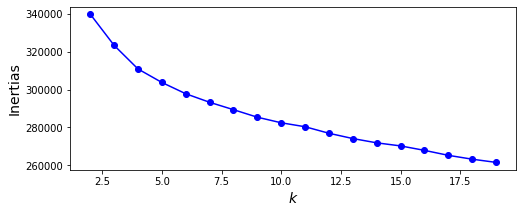

In [90]:
plt.figure(figsize=(8, 3))
plt.plot(clusters, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertias", fontsize=14)
plt.show()

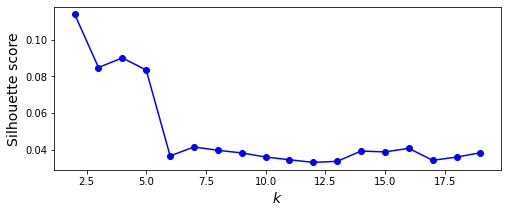

In [91]:
plt.figure(figsize=(8, 3))
plt.plot(clusters, sil_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

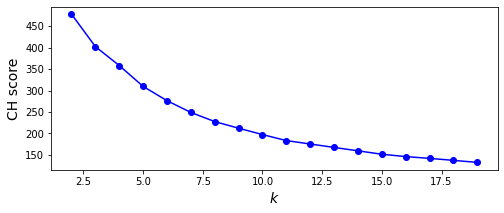

In [92]:
plt.figure(figsize=(8, 3))
plt.plot(clusters, ch_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("CH score", fontsize=14)
plt.show()

-> This does not do what I want, I want to transform each observation to de distance to its centroid.

#### Random Forest

In [111]:
model = RandomForestRegressor()
mse_scorer = make_scorer(custom_score, greater_is_better=False)
params = {
    'max_depth' : optuna.distributions.IntUniformDistribution(3, 10),
    'min_samples_split' : optuna.distributions.IntUniformDistribution(20, 300),
    'n_estimators' : optuna.distributions.IntUniformDistribution(16, 64),
}
linear_pipe = Pipeline(
    steps = [
        ('feature_clipper', Windsorizer()),
        ('normalizer', PowerTransformer()),
        ('random_search', optuna.integration.OptunaSearchCV(model, param_distributions=params, scoring=mse_scorer, n_trials = 10, verbose=5)),
    ]
)
linear_pipe.fit(X_train,y_train)
preds = linear_pipe.predict(X_test)
mse = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds))
mse , np.sqrt(mse)

C:\Users\fpala\AppData\Local\Temp\ipykernel_18152\2181646705.py:13: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  ('random_search', optuna.integration.OptunaSearchCV(model, param_distributions=params, scoring=mse_scorer, n_trials = 10, verbose=5)),
[I 2022-04-17 23:47:56,945] A new study created in memory with name: no-name-6a001472-deed-45b8-9b6b-a90fee79918e
[I 2022-04-17 23:47:56,946] Searching the best hyperparameters using 5925 samples...
[I 2022-04-17 23:48:14,384] Trial 0 finished with value: -1382.0388206659527 and parameters: {'max_depth': 6, 'min_samples_split': 287, 'n_estimators': 35}. Best is trial 0 with value: -1382.0388206659527.
[I 2022-04-17 23:48:39,254] Trial 1 finished with value: -1395.0640694656022 and parameters: {'max_depth': 4, 'min_samples_split': 298, 'n_estimators': 60}. Best is trial 0 with value: -1382.0388206659527.
[I 2022-04-17 23:49:08,369] Trial 2 finished with value: -1048.759

(487.62211972442856, 22.08216745984027)

In [112]:
linear_pipe['random_search'].best_params_

{'max_depth': 7, 'min_samples_split': 47, 'n_estimators': 28}

In [118]:
def objective(trial):
    params={
        "verbosity": 1,
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "booster": "gbtree",
        "min_child_weight": trial.suggest_int("min_child_weight", 50, 500),
        "alpha": trial.suggest_float("alpha", 1e-6, 1.0, log=True),
        "max_depth" : trial.suggest_int("max_depth", 3, 10),
        "colsample_bytree" : trial.suggest_float("colsample_bytree", 0.4, 1),
        "subsample" : trial.suggest_float("subsample", 0.5, 1),
        "eta" : trial.suggest_float("eta", 1e-2, 0.2, log=True)
        }
    xgb_pipe = Pipeline(
        steps = [
            ('feature_clipper', Windsorizer()),
            ('normalizer', PowerTransformer()),
            ('xgb', XGBRegressor(**params)),
        ]
    )
    xgb_pipe.fit(X_train,y_train)
    preds = xgb_pipe.predict(X_test)
    mse = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds))
    return mse

minutes = 10
study = optuna.create_study(direction='minimize')
study.optimize(objective, timeout=(60*minutes))
results = study.trials_dataframe()

[I 2022-04-18 00:12:18,184] A new study created in memory with name: no-name-75c22661-5311-4b51-9b63-17b17d814d3f
[I 2022-04-18 00:12:20,490] Trial 0 finished with value: 1551.8722231030272 and parameters: {'min_child_weight': 255, 'alpha': 3.612614570799724e-06, 'max_depth': 4, 'colsample_bytree': 0.6110366822651868, 'subsample': 0.9030618679204997, 'eta': 0.02720094833464392}. Best is trial 0 with value: 1551.8722231030272.
[I 2022-04-18 00:12:22,704] Trial 1 finished with value: 1248.7327576491066 and parameters: {'min_child_weight': 238, 'alpha': 0.031812027384019635, 'max_depth': 10, 'colsample_bytree': 0.47717709149788645, 'subsample': 0.5998712717824884, 'eta': 0.040490579032080046}. Best is trial 1 with value: 1248.7327576491066.
[I 2022-04-18 00:12:24,966] Trial 2 finished with value: 4103.4673444738855 and parameters: {'min_child_weight': 313, 'alpha': 2.46642672665775e-06, 'max_depth': 4, 'colsample_bytree': 0.7169970731813743, 'subsample': 0.6657403216026834, 'eta': 0.01151

In [174]:
idx_best = results.value.idxmin()
param_cols = [x for x in results.columns if x.startswith('params_')]
best_params = results.loc[idx_best, param_cols]
best_params.index = [x.replace('params_','') for x in best_params.index]
params = best_params.to_dict()

xgb_pipe = Pipeline(
        steps = [
            ('feature_clipper', Windsorizer()),
            ('normalizer', PowerTransformer()),
            ('xgb', XGBRegressor(**params)),
        ])

xgb_pipe.fit(X_train,y_train)
preds = xgb_pipe.predict(X_test)
mse = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(preds))
mse_train = mean_squared_error(y_true=np.exp(y_train), y_pred=np.exp(xgb_pipe.predict(X_train)))
mse , mse_train, np.sqrt(mse), params

(337.0709845015816,
 332.2849758381657,
 18.35949303498279,
 {'alpha': 0.005431704895799771,
  'colsample_bytree': 0.7063898876659078,
  'eta': 0.08220319061595308,
  'max_depth': 10,
  'min_child_weight': 58,
  'subsample': 0.9724863280502848})

In [171]:
pd.DataFrame(dict(zip(X_train.columns, xgb_pipe['xgb'].feature_importances_)),index=['importances']).T.sort_values(by='importances', ascending=False)

,importances
previousMarketCap,0.36454
revenue,0.13058
totalAssets,0.07059
ebitdaToRevenue,0.04531
netIncomeToRevenue,0.02819
operatingIncomeToRevenue,0.02491
researchAndDevelopmentExpensesToRevenue,0.02477
purchasesOfInvestmentsToRevenue,0.01935
PPEtoSales,0.01807
retainedEarningsToAssets,0.01783


In [133]:
X_train.columns

Index(['totalAssets', 'revenue', 'revenueYoY', 'revenueYoYSMA3',
       'previousMarketCap', 'cashAndCashEquivalentsToAssets',
       'shortTermInvestmentsToAssets', 'netReceivablesToAssets',
       'inventoryToAssets', 'otherCurrentAssetsToAssets',
       'propertyPlantEquipmentNetToAssets', 'intangibleAssetsToAssets',
       'longTermInvestmentsToAssets', 'otherNonCurrentAssetsToAssets',
       'accountPayablesToAssets', 'shortTermDebtToAssets',
       'deferredRevenueToAssets', 'otherCurrentLiabilitiesToAssets',
       'longTermDebtToAssets', 'otherNonCurrentLiabilitiesToAssets',
       'retainedEarningsToAssets', 'totalStockholdersEquityToAssets',
       'netDebtToAssets', 'costOfRevenueToRevenue',
       'researchAndDevelopmentExpensesToRevenue',
       'sellingGeneralAndAdministrativeExpensesToRevenue', 'ebitdaToRevenue',
       'operatingIncomeToRevenue', 'netIncomeToRevenue',
       'costOfRevenueToRevenueYearOverYear',
       'researchAndDevelopmentExpensesToRevenueYearOverYea

In [8]:
with open('../model/my_model.pickle', 'rb') as f:
    xgb = pickle.load(f)

In [12]:
data = pd.read_csv('../data/processed/test2.csv')
features = data.drop(columns=['target'])
target = data.target
preds = xgb.predict(features)
mse = mean_squared_error(y_true=np.exp(target), y_pred=np.exp(preds))

# v2
- clipping the the previousMarketCap feature destroys outliers. 
  - Filter clipping by kurtosis
  - Predict Increases
- Try to simulate a neural network with different algorithms